<div style='background-image: url("main.png") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 200px ; width: 100%'>
    <div style="float: right ; margin: 20px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.9) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , .8) ; line-height: 100%">Diffusion thermique
            </div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">Conduction unidimensionnelle avec conductivité variable| Étude transitoire
             </div>
        </div>
    </div>
</div>

In [221]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

# Mise en œuvre du problème physique
On étudie la résolution numérique de l'équation de la chaleur dans un système unidimensionnel, de conductivité $\lambda$ dépendant de $x$, sans terme source. Un tel système obéit à l'équation différentielle :
$$\dfrac{\partial T}{\partial t}=\dfrac{1}{\mu c_p}\dfrac{\partial}{\partial x}\left(\lambda(x)\dfrac{\partial T}{\partial x}\right)=\dfrac{1}{\mu c_p}\left(\dfrac{\partial \lambda}{\partial x}\dfrac{\partial T}{\partial x}+\lambda \dfrac{\partial^2 T}{\partial x^2} \right)$$

&nbsp;
Les conditions aux limites seront les suivantes : on imposera une température $T_g$ en $x=0$ et $T_d$ en $x=L$.

&nbsp;
On cherchera à tracer l'évolution de la température en fonction de $x$ au cours du temps.

## Paramètres physiques de la paroi étudiée :
Les grandeurs physiques à implémenter sont $\lambda$ notée `lambda_th`, $\mu$ notée `mu` et $c_p$ noté `cp` que l'on rassemblera sous la valeur du coefficient de diffusion thermique $D_\text{th}=\frac{\lambda}{\mu c_p}$ noté `Dth`, ainsi que la longueur du domaine de calcul $L$ notée `L_space`.

&nbsp;
La conductivité sera codée sous la forme d'une liste de longueur `N_space` contenant les valeurs de $\lambda$. On testera tout d'abord une variation brutale en $x=\frac{L}{2}$.
* $\left\lbrace\begin{array}{l}
x<\frac{L}{2}~:~\lambda(x)=\lambda_g \\
x\geq\frac{L}{2}~:~\lambda(x)=\lambda_d
\end{array}\right.$

&nbsp; 
On pourra également tester une variation linéaire de la conductivité, ou tout autre fonction continue : 
$$\lambda=\lambda_g-\frac{\lambda_d-\lambda_g}{L}x$$

In [236]:
mu = 100                  # masse volumique
cp = 10                   # capacité thermique
lambda_thg = 150
lambda_thd = 50
L_space = 1               # largeur du mur pour le cas plan

## Conditions aux limites : 
Les valeurs choisies sont les suivantes :
* $T_g=40~^\circ\text{C}$, notée `Tg`,
* $T_d=10~^\circ\text{C}$, notée `Td`.

In [237]:
Tg=40               # température à gauche
Td=10               # température à droite

## Paramètres numériques de la simulation 
La durée de la simulation et les paramètres de discrétisation sont également renseignés :
* durée : $T=2~\text{s}$, noté `L_time`,
* nombre d'intervalles de temps $N_t$, noté `N_time`,
* nombre d'intervalles d'espace $N_x$, noté `N_space`.

In [238]:
## Attention! la convergence numérique est conditionnelle, si N_space augmente, N_time doit également augmenter
L_time=2                 # durée de la simulation
N_time=3000              # discrétisation spatiale
N_space=50               # discrétisation temporelle
dx=L_space/(N_space-1)   # pas d'espace
dt=L_time/(N_time-1)     # pas de temps

On peut alors coder la conductivité :

In [239]:
## Variation brutale (décommenter les lignes ci-dessous)
#lambda_th=[lambda_thg for i in range(N_space)]
#for i in range(N_space):
#    if i*dx > L_space/2:
#        lambda_th[i]=lambda_thd
        
## Variation linéaire (décommenter les lignes ci-dessous)
lambda_th=[lambda_thg +(lambda_thg-lambda_thd)*i*dx/L_space for i in range(N_space)]

# Résolution numérique du problème physique
## Schéma numérique pour le calcul de $\Delta T$
La relation de Taylor écrite en $x+\text{d}x$ et $x-\text{d}x$ permet d'établir :
$$\left\lbrace
\begin{array}{l}
T(x+\text{d}x) \simeq T(x) + \text{d}x \dfrac{\partial T}{\partial x} + \dfrac{\text{d}x^2}{2} \dfrac{\partial^2 T}{\partial x^2}\\
T(x-\text{d}x) \simeq T(x) - \text{d}x \dfrac{\partial T}{\partial x} + \dfrac{\text{d}x^2}{2} \dfrac{\partial^2 T}{\partial x^2}
\end{array}
\right.$$


dont on peut déduire l'approximation suivante :
$$\dfrac{\partial^2 T}{\partial x^2}\simeq\dfrac{T(x+\text{d}x)-2T(x)+T(x+\text{d}x)}{\text{d}x^2}$$


En remarquant que $x$ est représenté par `x[i]` et est donc égal à $i\times \text{d}x$, soit `x[i]=i*dx`, et notant $T(x)=T(i\text{d}x)=T_{i}$, il vient :
$$\begin{array}{l}
T(x+\text{d}x)=T((i+1)\Delta x)=T_{i+1}\\
T(x-\text{d}x)=T((i-1)\Delta x)=T_{i-1}
\end{array}$$


On peut donc approximer le calcul du laplacien en coordonnées cartésiennes au point $x$ par :
$$\boxed{\Delta T_i\simeq \dfrac{T_{i+1}-2 T_i + T_{i-1}}{\Delta x^2}}$$

&nbsp;
La liste (où le vecteur) permettant de stocker les valeurs de température ayant un nombre d'éléments fixé `N_space`, on doit alors traiter séparément le calcul du laplacien aux points `i = 0` et `i = N-1` en exploitant les conditions aux limites.
* À gauche de `i = 0` la température est connue et vaut `Tg`,
* À droite de `i = N_space-1` la température est connue et vaut `Td`.


In [240]:
def laplacien_cart(liste,dx,liste_g,liste_d):
    n=len(liste)
    result=[0 for i in range(N_space)]
    for i in range(1,n-1):
        result[i]=(liste[i+1]-2*liste[i]+liste[i-1])/dx**2
    result[0]=(liste[1]-2*liste[0]+liste_g)/dx**2         #liste[-1] ne donne pas la bonne température 
    result[n-1]=(liste_d-2*liste[n-1]+liste[n-1-1])/dx**2   #liste[n] n'est pas définie
    return result

## Dérivée spatiale simple d'une grandeur quelconque
On note $U$ une fonction de $x$ quelconque, en utilisant les développements de Taylor précédents, on peut écrire : 
$$\dfrac{\partial U}{\partial x}\simeq \dfrac{U(x+\text{dx})-U(x-\text{d}x)}{2\text{d}x}$$

&nbsp;
En utilisant les notations introduites précédemment, il vient alors :
$$\boxed{\dfrac{\partial U}{\partial x}_i\simeq \dfrac{U_{i+1}-U_{i-1}}{2\Delta x}}$$

&nbsp;
&nbsp;
La liste (où le vecteur) permettant de stocker les valeurs de température ou de conductivité thermique ayant un nombre d'éléments fixé `N_space`, on doit alors traiter séparément le calcul de la dérivée partielle aux points `i = 0` et `i = N-1` en exploitant les conditions aux limites.
* À gauche de `i = 0` la température est connue et vaut `Tg`, la conductivité est connue et vaut $\lambda(x=0)$,
* À droite de `i = N_space-1` la température est connue et vaut `Td`, la conductivité est connue et vaut $\lambda(x=L)$.

In [241]:
def der_x(liste,dx,liste_g,liste_d):
    n=len(liste)
    result=[0 for i in range(N_space)]
    for i in range(1,n-1):
        result[i]=(liste[i]-liste[i-1])/dx
    result[0]=(liste[1]-liste[0])/dx         #liste[-1] ne donne pas la bonne température 
    result[n-1]=(liste[n-1]-liste[n-1-1])/dx   #liste[n] n'est pas définie
    return result

## Dérivée temporelle

En s'inspirant de ce qui a été fait pour le laplacien, on peut écrire :
$$\dfrac{\partial T}{\partial t}\simeq \dfrac{T(t+\text{d}t) - T(t)}{\text{d}t}$$

&nbsp;
En discrétisant le temps comme nous l'avons fait pour l'espace (on prendra l'indice $k$, et on le notera en exposant pour le différencier de l'indice $i$ spatial), il vient :
$$\boxed{\dfrac{\partial T}{\partial t}^k \simeq \dfrac{T^{k+1} - T^k}{\Delta t}}$$

&nbsp;


## Implémentation finale
Ainsi l'expression discrète de l'équation de la chaleur en 1D cartésien peut s'exprimer sous la forme :
$$\dfrac{T^{k+1}_i - T^k_i}{\Delta t} = \dfrac{1}{\mu c_p}\left(\dfrac{\lambda_{i+1}-\lambda_{i-1}}{2\Delta x}\dfrac{T_{i+1}^k-T_{i-1}^k}{2\Delta x}+\lambda_i\times\left( \dfrac{T_{i+1}^k-2 T_i^k + T_{i-1}^k}{\Delta x^2}\right)\right)$$

&nbsp;
Cette relation permet d'écrire de façon explicite :
$$\boxed{T^{k+1}_i=T^k_i+\Delta t\times\dfrac{1}{\mu c_p}\left(\dfrac{\lambda_{i+1}-\lambda_{i-1}}{2\Delta x}\dfrac{T_{i+1}^k-T_{i-1}^k}{2\Delta x}+\lambda_i\times\left( \dfrac{T_{i+1}^k-2 T_i^k + T_{i-1}^k}{\Delta x^2}\right)\right)}$$

&nbsp;
La connaissance des diverses valeurs de $T_i^k$ pour $i\in[0,N_x]$ permet donc de &laquo;prévoir&raquo; l'ensemble des valeurs futures de $T_i^{k+1}$, à condition de lui donner une première liste de valeurs correspondant à $T_i^{k=0}$. Il faut donc commencer par initialiser la température.

### Initialisation de la température dans la paroi
La température initiale $T_\text{init}$ est noté `Tinit`. On l'utilise pour initialiser une première liste qui permettra le stockage de l'évolution spatiale de la température à tout instant.

In [242]:
Tinit=25
T=[Tinit for i in range(N_space)] #la paroi est initialisée à 25°C en tous points

### Calcul par récurrence et affichage de la carte de température
Il ne reste alors qu'à calculer itérativement les températures en tout point du mur pour les divers instants. On procède pour celà par étapes :
* on calcule le laplacien à l'aide de la fonction `laplacien_cart` en lui donnant les bons arguments `T, dx, Tg, Td`,
* on calcul de même les dérivées premières de la température et de la conductivité thermique à l'aide de la fonction `der_x` en lui donnant les bons arguments : tantôt `T, dx, Tg, Td`, tantôt `lambda_th, dx, lambda_thg, lambda_thd`,
* on impose les conditions aux limites `T[0]=Tg`et `T[N_space-1]=Td`,
* on calcule la nouvelle distribution de température avec la relation ci-desssus. 

&nbsp;
L'affichage de la carte de température se fait avec les lignes de code ci-dessous, qu'il vaut mieux ne pas trop modifier...


<IPython.core.display.Javascript object>


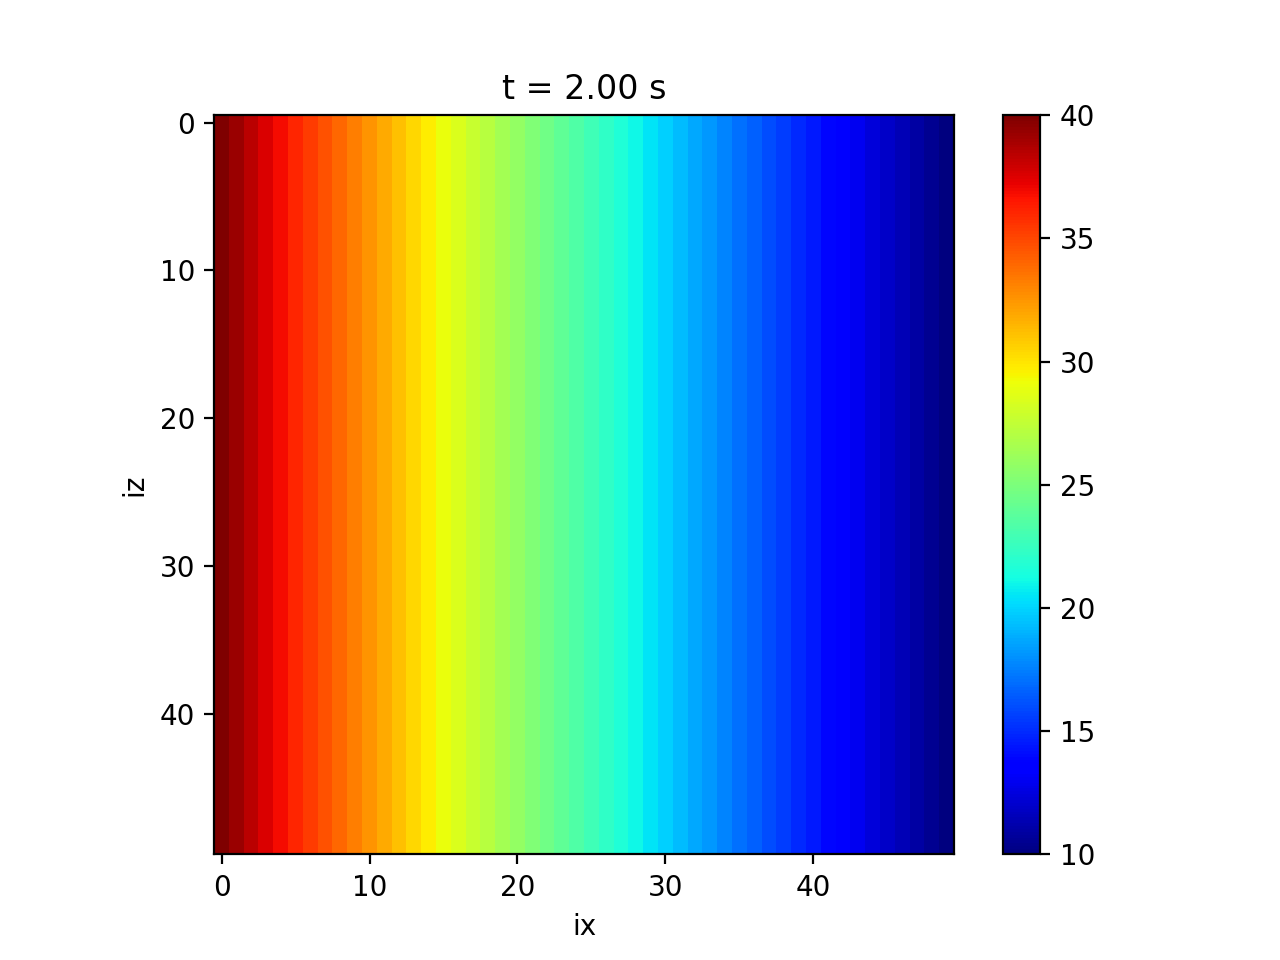

In [248]:
Temp=[T for i in range(N_space)] # on bidimensionnalise le résultat de calcul en le copiant "verticalement"
plt.figure('Cas cartésien')
image = plt.imshow(Temp, interpolation='nearest', animated=True, clim=(10,40), cmap='jet')
plt.colorbar()
plt.xlabel('ix')
plt.ylabel('iz')
plt.ion()

Le calcul peut alors être lancé et la carte de température ci-dessous va se mettre à jour tous les `100dt`.

In [249]:
for i in range(N_time+1):
    delta_T=laplacien_cart(T,dx,Tg,Td)  
    der_T=der_x(T,dx,Tg,Td)
    der_lambda=der_x(lambda_th,dx,lambda_thg,lambda_thd) 
    T[0],T[N_space-1]=Tg,Td
    for j in range(1,N_space-1):
        T[j]=T[j]+dt*(lambda_th[j]*delta_T[j]+der_T[j]*der_lambda[j])/(mu*cp)
        if i % 100 == 0:    # you can change the speed of the plot by increasing the plotting interval
            Temp=[T for i in range(N_space)]
            time=i*dt
            plt.title("t = %.2f s" % time)
            image.set_data(Temp)
            plt.gcf().canvas.draw()
        

Lorsque la simulation précédente est terminée, il ne reste finalement qu'à comparer le résultat numérique et le résultat théorique pour valider la démarche.

<IPython.core.display.Javascript object>


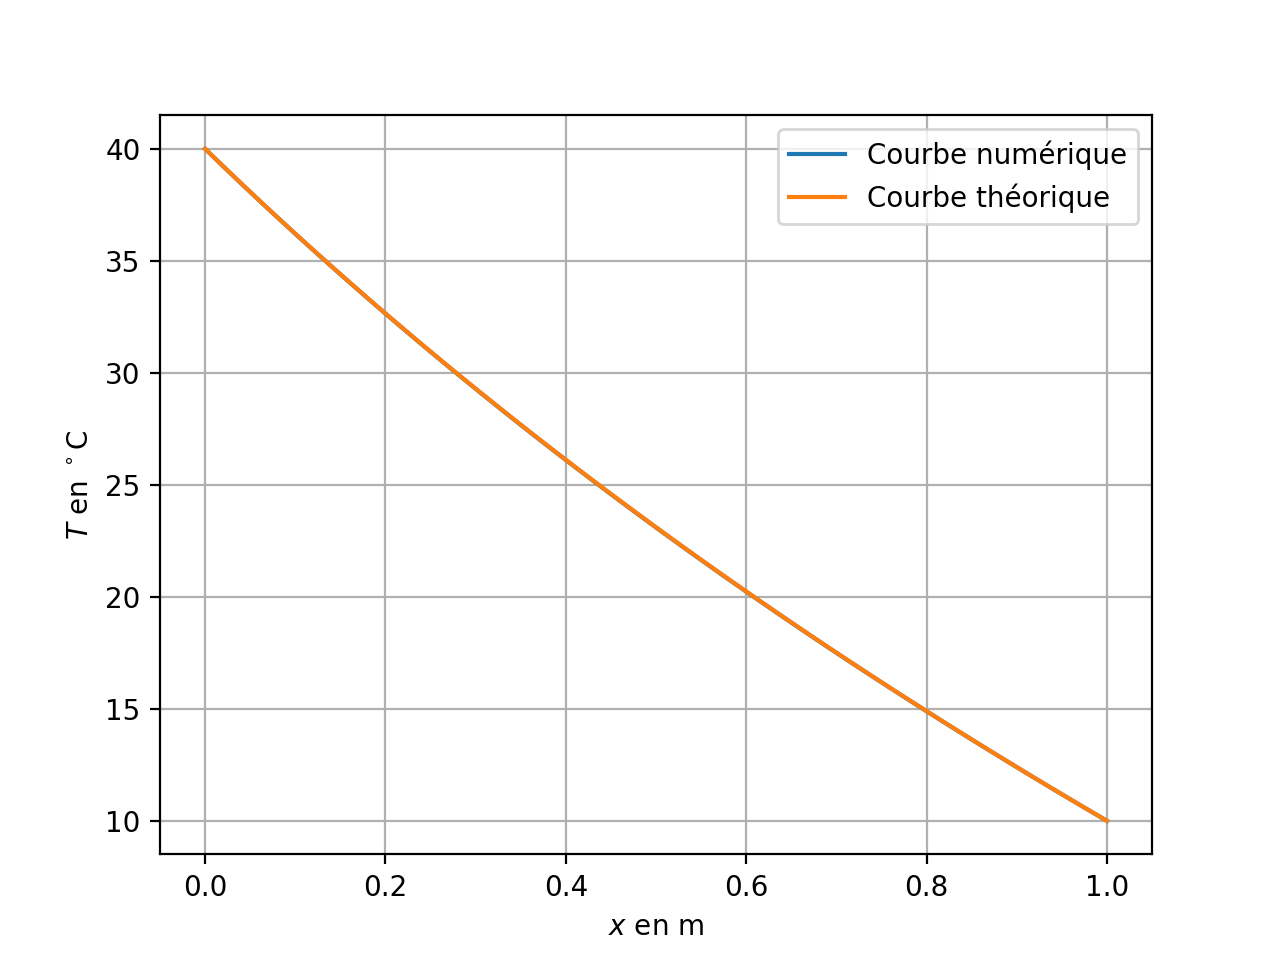

In [250]:
plt.figure('Température sur l\'axe du mur')
x=np.linspace(0,L_space, N_space)

plt.plot(x, T, label='Courbe numérique')

T_th=2*lambda_thd*(Td-Tg)*x/(L_space*(lambda_thd+lambda_thg))+Tg # Décommenter si variation brutale
for i in range(N_space):
    if i*dx > L_space/2:
        T_th[i]=2*lambda_thg*(Td-Tg)*(x[i]-L_space)/(L_space*(lambda_thd+lambda_thg))+Td

# Commenter les lignes ci-dessous dans le cas d'une variation brutale
alpha=(lambda_thg-lambda_thd)/L_space
T_th=Tg+(Td-Tg)*np.log((lambda_thg+alpha*x)/lambda_thg)/np.log((lambda_thg+alpha*L_space)/lambda_thg) 

plt.plot(x,T_th, label='Courbe théorique') 

plt.legend()
plt.xlabel("$x$ en m")
plt.ylabel("$T$ en $^\circ$C")
plt.grid(True)
plt.show()

*Note :* Pour des raisons que j'ignore à ce jour, il faut relancer la toute première ligne de code (celle contenant `% matplotlib ...` pour pouvoir faire tourner à nouveau la mise à jour des courbes...

In [251]:
print(T[N_space//2], T_th[N_space//2])

22.796187945202625 22.806002968243586
